In [276]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

In [180]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 10
batch_size = 4
learning_rate = 0.001

# load data set and clean data

In [181]:
print(os.getcwd())

/Users/wangyuhang/Desktop/third semester/affective computing/pytorch_lab_git/pytorch_git_Bruce/pytorch_test/RNN_LSTM


In [182]:
target_file_path = "/Users/wangyuhang/Desktop/third semester/affective computing/pytorch_lab_git/pytorch_git_Bruce/pytorch_test/RNN_LSTM/archive/prices.csv"
target_df = pd.read_csv(target_file_path)

print("Full train dataset shape is {}".format(target_df.shape))
target_df.info()

Full train dataset shape is (851264, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [183]:
train_file_path = "/Users/wangyuhang/Desktop/third semester/affective computing/pytorch_lab_git/pytorch_git_Bruce/pytorch_test/RNN_LSTM/archive/fundamentals.csv"
dataset_df = pd.read_csv(train_file_path)

print("Full train dataset shape is {}".format(dataset_df.shape))
print(dataset_df.isnull().sum())
dataset_df=dataset_df.dropna()
print(dataset_df.isnull().sum())
print("Full train dataset shape is {}".format(dataset_df.shape))



numeric_df = dataset_df.select_dtypes(include=['number'])

for i in numeric_df:
    dataset_df[i] = dataset_df[i].astype('int64')
# avoid the science number function



Full train dataset shape is (1781, 79)
Unnamed: 0                        0
Ticker Symbol                     0
Period Ending                     0
Accounts Payable                  0
Accounts Receivable               0
                               ... 
Total Revenue                     0
Treasury Stock                    0
For Year                        173
Earnings Per Share              219
Estimated Shares Outstanding    219
Length: 79, dtype: int64
Unnamed: 0                      0
Ticker Symbol                   0
Period Ending                   0
Accounts Payable                0
Accounts Receivable             0
                               ..
Total Revenue                   0
Treasury Stock                  0
For Year                        0
Earnings Per Share              0
Estimated Shares Outstanding    0
Length: 79, dtype: int64
Full train dataset shape is (1299, 79)


In [184]:
dataset_df = dataset_df.drop('Unnamed: 0', axis=1)

dataset_df.dtypes

Ticker Symbol                   object
Period Ending                   object
Accounts Payable                 int64
Accounts Receivable              int64
Add'l income/expense items       int64
                                 ...  
Total Revenue                    int64
Treasury Stock                   int64
For Year                         int64
Earnings Per Share               int64
Estimated Shares Outstanding     int64
Length: 78, dtype: object

In [185]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1299 entries, 0 to 1779
Data columns (total 78 columns):
 #   Column                                               Non-Null Count  Dtype 
---  ------                                               --------------  ----- 
 0   Ticker Symbol                                        1299 non-null   object
 1   Period Ending                                        1299 non-null   object
 2   Accounts Payable                                     1299 non-null   int64 
 3   Accounts Receivable                                  1299 non-null   int64 
 4   Add'l income/expense items                           1299 non-null   int64 
 5   After Tax ROE                                        1299 non-null   int64 
 6   Capital Expenditures                                 1299 non-null   int64 
 7   Capital Surplus                                      1299 non-null   int64 
 8   Cash Ratio                                           1299 non-null   int64 
 9   Ca

## search and check the same raw in target_df and dataset_df at two columns('date', 'symbol') and ('Period Ending', 'Ticker Symbol')

In [187]:

# I want to check the intersection of the target_df and dataset_df
matching_rows = pd.merge(target_df, dataset_df, left_on=['date', 'symbol'], right_on=['Period Ending', 'Ticker Symbol'])

matching_rows = matching_rows[target_df.columns]

matching_rows['increase of stock'] = matching_rows['close'] - matching_rows['open']


print(matching_rows[matching_rows['symbol'] == "ADI"])


Empty DataFrame
Columns: [date, symbol, open, close, low, high, volume, increase of stock]
Index: []


In [188]:
matching_rows

,date,symbol,open,close,low,high,volume,increase of stock
0,2012-12-31,AAL,12.850000,13.500000,12.840000,13.680000,7005600.0,0.650000
1,2012-12-31,ABT,64.129942,65.499944,64.009943,65.529941,19018100.0,1.370002
2,2012-12-31,ADS,143.539993,144.759995,143.190002,144.970001,364500.0,1.220002
3,2012-12-31,AEE,30.309999,30.719999,30.180000,30.820000,2461100.0,0.410000
4,2012-12-31,AEP,42.119999,42.680000,41.919998,42.730000,3289000.0,0.560001
...,...,...,...,...,...,...,...,...
1011,2016-09-30,WRK,47.830002,48.480000,47.615002,48.700001,1932400.0,0.649998
1012,2016-10-31,COO,175.910004,176.039993,174.509995,176.309998,322000.0,0.129989
1013,2016-10-31,DE,87.919998,88.300003,87.800003,88.849998,2536400.0,0.380005
1014,2016-10-31,HPE,22.250000,22.469999,22.219999,22.520000,8140900.0,0.219999


In [211]:
print(len(matching_rows['symbol']))
print(len(dataset_df['Ticker Symbol']))

common_values = set(matching_rows['symbol']).intersection(set(dataset_df['Ticker Symbol']))
print(len(common_values))
filtered_dataframe1 = dataset_df[dataset_df['Ticker Symbol'].isin(common_values)]
print(len(filtered_dataframe1))


1016
1299
298
1070


In [231]:
common_values = set(filtered_dataframe1['Period Ending']).intersection(set(matching_rows['date']))

DF_dataset = filtered_dataframe1[filtered_dataframe1['Period Ending'].isin(common_values)]

print(matching_rows['symbol'].nunique()
)
print(DF_dataset['Ticker Symbol'].nunique()
)
duplicates = DF_dataset[DF_dataset.duplicated()]
print("check duplicates rows:", len(duplicates))

298
298
check duplicates rows: 0


In [249]:
plt.figure(figsize=(200, 60))

sns.histplot(DF_dataset['Ticker Symbol'], color='blue', kde=True, label='Data1', alpha=1)

sns.histplot(matching_rows['symbol'], color='orange', kde=True, label='Data2', alpha=1)

plt.title('Comparison of Two Datasets')
plt.xlabel('Column Name')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [253]:
#FBHS HCA MPC PSX TRIP XYL they are different in two dataframes

print(len(matching_rows[matching_rows['symbol'] == "FBHS"]))
print(len(DF_dataset[DF_dataset['Ticker Symbol'] == "FBHS"]))

print(len(matching_rows[matching_rows['symbol'] == "HCA"]))
print(len(DF_dataset[DF_dataset['Ticker Symbol'] == "HCA"]))

print(len(matching_rows[matching_rows['symbol'] == "MPC"]))
print(len(DF_dataset[DF_dataset['Ticker Symbol'] == "MPC"]))

print(len(matching_rows[matching_rows['symbol'] == "PSX"]))
print(len(DF_dataset[DF_dataset['Ticker Symbol'] == "PSX"]))

print(len(matching_rows[matching_rows['symbol'] == "TRIP"]))
print(len(DF_dataset[DF_dataset['Ticker Symbol'] == "TRIP"]))

print(len(matching_rows[matching_rows['symbol'] == "XYL"]))
print(len(DF_dataset[DF_dataset['Ticker Symbol'] == "XYL"]))

3
4
3
4
3
4
3
4
3
4
3
4


In [254]:
matching_rows[matching_rows['symbol'] == "FBHS"]

,date,symbol,open,close,low,high,volume,increase of stock
275,2013-12-31,FBHS,45.779999,45.700001,45.560001,46.080002,598500.0,-0.079998
553,2014-12-31,FBHS,45.259998,45.270000,44.980000,45.950001,1073400.0,0.010002
819,2015-12-31,FBHS,56.160000,55.500000,55.500000,56.529999,630000.0,-0.660000


In [255]:
DF_dataset[DF_dataset['Ticker Symbol'] == "FBHS"]

,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
620,FBHS,2012-12-31,287000000,-33500000,500000,5,-75000000,2324800000,53,336000000,...,1227900000,632400000,2381100000,1492800000,3873900000,3134800000,-16900000,2012,0,160405405
621,FBHS,2013-12-31,314800000,-58500000,-5300000,9,-96700000,2431300000,33,241400000,...,1327400000,738700000,2649400000,1528700000,4178100000,3703600000,-79800000,2013,1,165251798
622,FBHS,2014-12-31,333800000,-39900000,-1200000,7,-127500000,2517300000,27,191900000,...,1299100000,699600000,2259500000,1793400000,4052900000,4013600000,-532300000,2014,0,161326530
623,FBHS,2015-12-31,344200000,-6900000,-4300000,13,-128500000,2602200000,31,238500000,...,1418700000,757900000,2450900000,2427700000,4878600000,4579400000,-602100000,2015,1,159898477


In [259]:
#DF_dataset.drop(index=620, inplace=True)
DF_dataset[DF_dataset['Ticker Symbol'] == "FBHS"]

,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
621,FBHS,2013-12-31,314800000,-58500000,-5300000,9,-96700000,2431300000,33,241400000,...,1327400000,738700000,2649400000,1528700000,4178100000,3703600000,-79800000,2013,1,165251798
622,FBHS,2014-12-31,333800000,-39900000,-1200000,7,-127500000,2517300000,27,191900000,...,1299100000,699600000,2259500000,1793400000,4052900000,4013600000,-532300000,2014,0,161326530
623,FBHS,2015-12-31,344200000,-6900000,-4300000,13,-128500000,2602200000,31,238500000,...,1418700000,757900000,2450900000,2427700000,4878600000,4579400000,-602100000,2015,1,159898477


In [261]:
matching_rows[matching_rows['symbol'] == "HCA"]

,date,symbol,open,close,low,high,volume,increase of stock
294,2013-12-31,HCA,47.250000,47.709999,47.180000,47.980000,1499800.0,0.459999
571,2014-12-31,HCA,74.540001,73.389999,73.300003,74.919998,1470200.0,-1.150002
838,2015-12-31,HCA,67.949997,67.629997,67.599998,68.860001,2320200.0,-0.320000


In [262]:
#HCA
DF_dataset.drop(index=748, inplace=True)

/var/folders/3y/q4jbmcr9193448_7sqhrrvyw0000gn/T/ipykernel_72408/333973342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_dataset.drop(index=748, inplace=True)


In [265]:
DF_dataset[DF_dataset['Ticker Symbol'] == "MPC"]
DF_dataset.drop(index=1095, inplace=True)

/var/folders/3y/q4jbmcr9193448_7sqhrrvyw0000gn/T/ipykernel_72408/1036834949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_dataset.drop(index=1095, inplace=True)


In [271]:
#PSX TRIP XYL
DF_dataset[DF_dataset['Ticker Symbol'] == "XYL"]
DF_dataset.drop(index=1757, inplace=True)

/var/folders/3y/q4jbmcr9193448_7sqhrrvyw0000gn/T/ipykernel_72408/708279825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_dataset.drop(index=1757, inplace=True)


In [272]:
plt.figure(figsize=(200, 60))

sns.histplot(DF_dataset['Ticker Symbol'], color='blue', kde=True, label='Data1', alpha=1)

sns.histplot(matching_rows['symbol'], color='orange', kde=True, label='Data2', alpha=1)

plt.title('Comparison of Two Datasets')
plt.xlabel('Column Name')
plt.ylabel('Frequency')
plt.legend()

plt.show()

## connect two data frames as the full data set and split train and test set.

In [302]:
DF_dataset['increase of stock'] = matching_rows['increase of stock']
DF_dataset.head(3)
DF_dataset['increase of stock'].isna()
DF_dataset['increase of stock'].fillna(0, inplace=True)


/var/folders/3y/q4jbmcr9193448_7sqhrrvyw0000gn/T/ipykernel_72408/1080786861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_dataset['increase of stock'] = matching_rows['increase of stock']
/var/folders/3y/q4jbmcr9193448_7sqhrrvyw0000gn/T/ipykernel_72408/1080786861.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation

In [303]:
DF_num = DF_dataset.select_dtypes(include = ['float64', 'int64'])
DF_num.head()

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding,increase of stock
0,3068000000,-222000000,-1961000000,23,-1888000000,4695000000,53,1330000000,0,127000000,...,9011000000,-7987000000,24891000000,16904000000,24855000000,-367000000,2012,-5,335000000,0.650000
1,4975000000,-93000000,-2723000000,67,-3114000000,10592000000,75,2175000000,0,5000000,...,13806000000,-2731000000,45009000000,42278000000,26743000000,0,2013,-11,163022222,1.370002
2,4668000000,-160000000,-150000000,143,-5311000000,15135000000,60,1768000000,0,7000000,...,13404000000,2021000000,41204000000,43225000000,42650000000,0,2014,4,716915422,1.220002
3,5102000000,352000000,-708000000,135,-6151000000,11591000000,51,1085000000,0,6000000,...,13605000000,5635000000,42780000000,48415000000,40990000000,0,2015,11,668129938,0.410000
13,6448000000,681000000,-54000000,92,-491000000,3671000000,144,9595000000,-56000000,16000000,...,6879000000,4492000000,24706000000,29198000000,18790000000,-320000000,2013,2,1600000000,0.120000


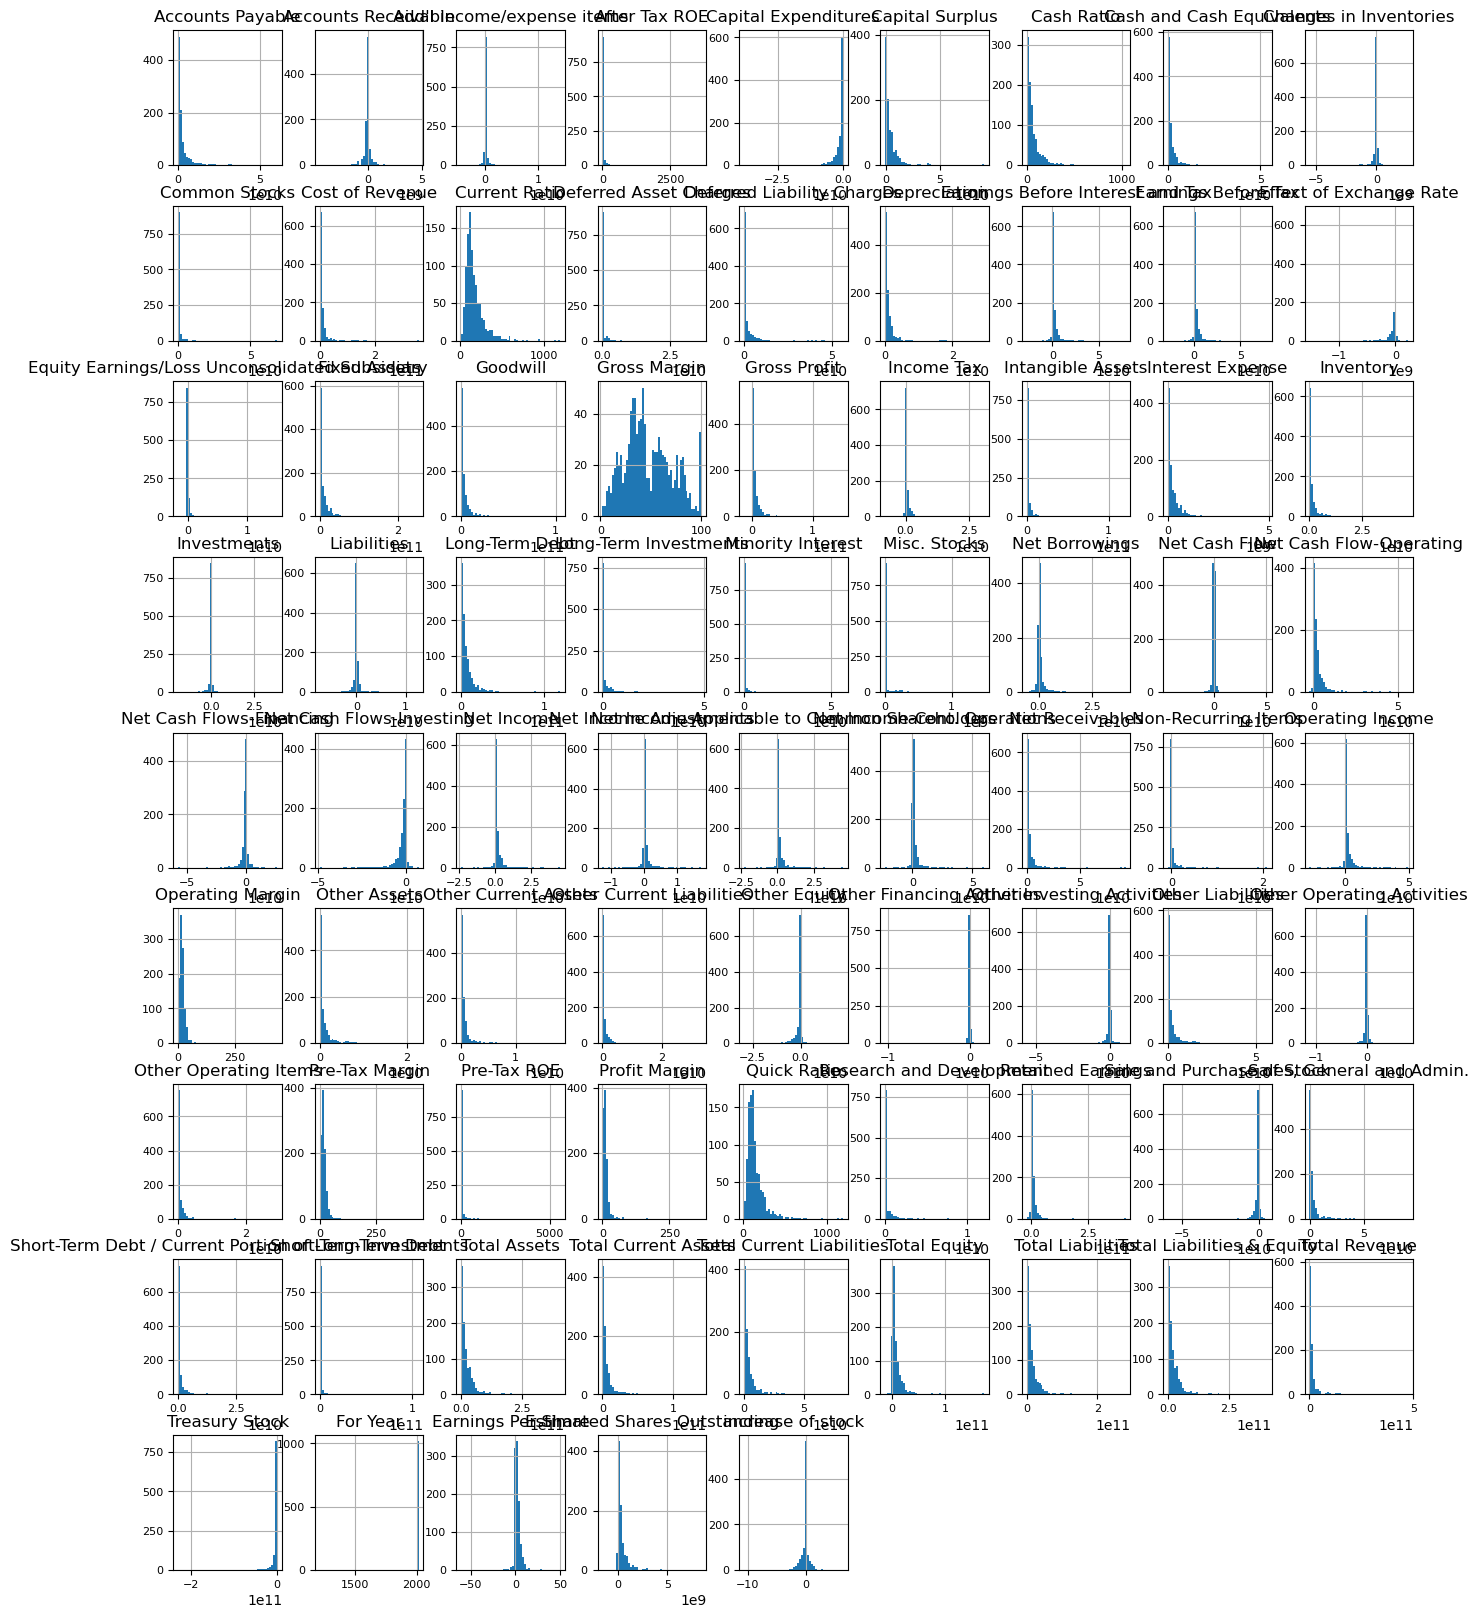

In [304]:
DF_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [305]:
X = DF_num.iloc[:, :-1]  # 特征
y = DF_num['increase of stock']  # 目标变量

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [306]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_data_X_train = scaler.fit_transform(X_train)
scaled_data_X_test = scaler.fit_transform(X_test)



In [307]:
scaled_data_X_train

array([[-0.29587034,  0.36247424,  0.09913508, ...,  0.04300287,
         0.41938306, -0.40546635],
       [ 0.60127156,  2.94653995,  2.68622813, ...,  0.04300287,
        -0.52708455,  0.19236448],
       [ 1.15717575,  1.59187803, -0.67248305, ...,  0.04300287,
         0.04079602,  0.55187852],
       ...,
       [-0.47747137,  0.31737362, -0.12440439, ...,  0.04300287,
        -0.1484975 , -0.43247297],
       [ 0.13417169, -0.2838077 ,  0.62907074, ...,  0.04300287,
         0.79797011, -0.28826349],
       [-0.10470921, -0.0713903 , -0.14036785, ...,  0.04300287,
         0.23008954, -0.05663203]])